In [205]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!pip install opencv-python-headless scikit-image matplotlib numpy

In [206]:
#to unzip
import zipfile
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import exposure, filters, morphology, util

# **Image Pre-processing code for LIVECELL**

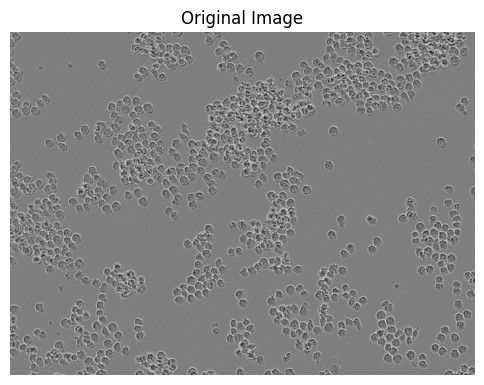

In [207]:
# example image path (change this to your preprocessed image)
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/A172/A172_Phase_A7_1_00d00h00m_1.png"
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_D4_2_03d00h00m_3.tif"
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/A172/A172_Phase_A7_2_00d00h00m_1.png"
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_1_03d00h00m_3.tif"
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_2_00d20h00m_3.tif"
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_1_01d08h00m_1.tif"
# img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_C4_2_01d20h00m_1.tif"
img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_1_02d00h00m_1.tif"

# read the image in grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


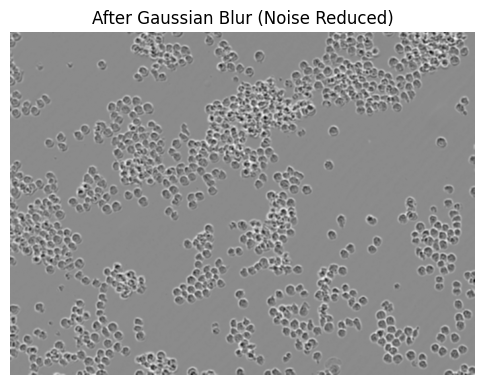

In [208]:
# apply Gaussian Blur to smooth noise while keeping edges soft
blurred = cv2.GaussianBlur(img, (5,5), 0)

plt.figure(figsize=(6,6))
plt.imshow(blurred, cmap='gray')
plt.title("After Gaussian Blur (Noise Reduced)")
plt.axis('off')
plt.show()

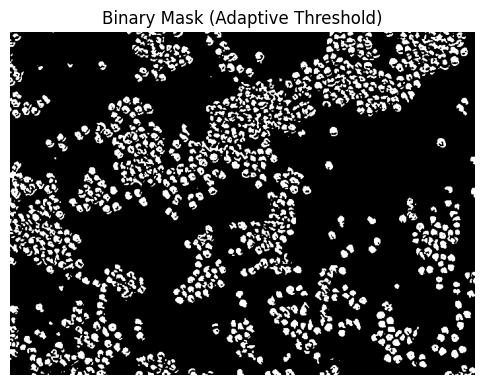

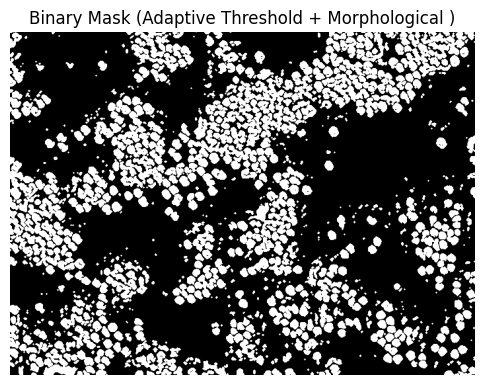

In [209]:
# apply adaptive thresholding to separate foreground (cells) from background
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 71, 5)

plt.figure(figsize=(6,6))
plt.imshow(thresh, cmap='gray')
plt.title("Binary Mask (Adaptive Threshold)")
plt.axis('off')
plt.show()


# Adaptive Threshold + Morphological Correction
thresh = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    31,    # increase window
    2      # decrease C (less shrinkage)
)

# Fix shrinkage → Expand cell boundaries
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
thresh_corrected = cv2.dilate(thresh, kernel, iterations=1)

plt.figure(figsize=(6,6))
plt.imshow(thresh_corrected, cmap='gray')
plt.title("Binary Mask (Adaptive Threshold + Morphological )")
plt.axis('off')
plt.show()

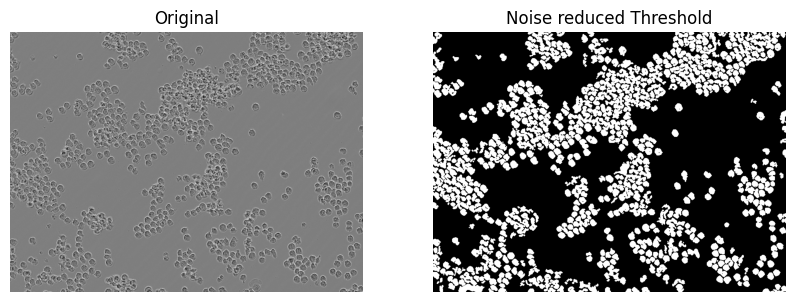

In [210]:
# Find connected components
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh_corrected, connectivity=8)

# stats[:, cv2.CC_STAT_AREA] gives the size of each component
min_size = 60  # adjust

cleaned = np.zeros_like(thresh_corrected)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        cleaned[labels == i] = 255



plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cleaned, cmap='gray')
plt.title("Noise reduced Threshold")
plt.axis('off')

plt.show()


### Applying Histogram Equalization

You can apply standard histogram equalization or Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance the image contrast. CLAHE is often preferred for medical or biological images as it prevents over-amplification of noise in homogeneous areas.

In [211]:
# # Use the original image loaded earlier (assuming 'img' is still available)
# # If not, reload it:
# # img_path = "/content/drive/MyDrive/LIVECell_dataset_2021/images/livecell_train_val_images/A172/A172_Phase_A7_2_00d00h00m_1.png" # Or your image path
# # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# # Apply standard Histogram Equalization
# hist_eq = cv2.equalizeHist(img)

# # Apply CLAHE (often better for this type of image)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# clahe_img = clahe.apply(img)

# # Display results
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 3, 1)
# plt.imshow(img, cmap='gray')
# plt.title("Original Image")
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(hist_eq, cmap='gray')
# plt.title("Histogram Equalization")
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.imshow(clahe_img, cmap='gray')
# plt.title("CLAHE")
# plt.axis('off')

# plt.show()

### Using Enhanced Image for Adaptive Thresholding

You can then use the CLAHE-enhanced image as the input for your adaptive thresholding step. This might help in cases where the original image has poor contrast overall.

In [212]:
# # Use the CLAHE enhanced image for adaptive thresholding
# # (Assuming 'clahe_img' from the previous cell is available)

# thresh_clahe = cv2.adaptiveThreshold(clahe_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
#                                      cv2.THRESH_BINARY_INV, 21, 10) # You can experiment with block size and C

# plt.figure(figsize=(6,6))
# plt.imshow(thresh_clahe, cmap='gray')
# plt.title("Adaptive Thresholding on CLAHE Image")
# plt.axis('off')
# plt.show()

# **Laplacian --> Histograms**

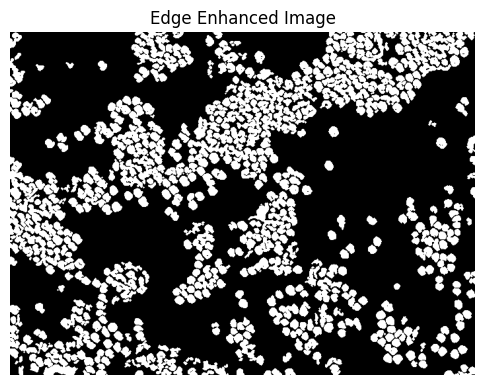

In [213]:
# Apply Laplacian for edge enhancement
lap = cv2.Laplacian(cleaned, cv2.CV_64F)
lap = cv2.convertScaleAbs(lap)
edge_enhanced = cv2.addWeighted(cleaned, 1.5, lap, -0.5, 0)

plt.figure(figsize=(6,6))
plt.imshow(edge_enhanced, cmap='gray')
plt.title("Edge Enhanced Image")
plt.axis('off')
plt.show()

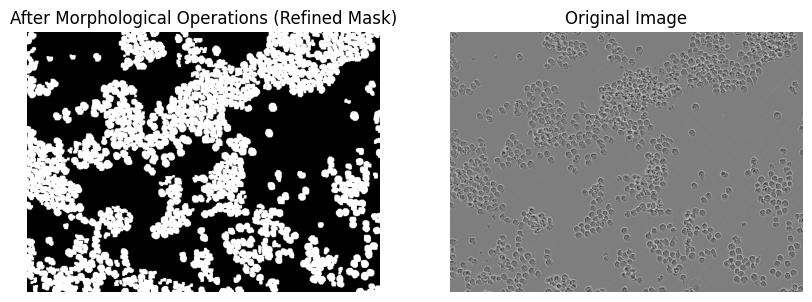

In [214]:
# remove small noise and fill small holes
kernel = np.ones((3,3), np.uint8)
cleaned = cv2.morphologyEx(edge_enhanced, cv2.MORPH_OPEN, kernel, iterations=1)
cleaned = cv2.dilate(cleaned, kernel, iterations=1)


img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(cleaned, cmap='gray')
plt.title("After Morphological Operations (Refined Mask)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

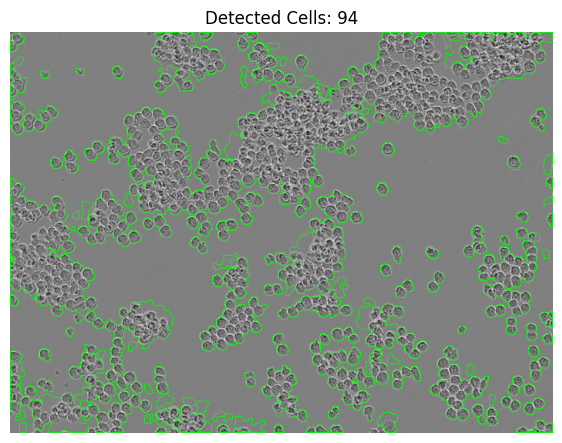

In [215]:
# Find contours (boundaries of objects)
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a color copy to visualize
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw only contours (no boxes or text)
valid_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 5:  # filter very small objects
        valid_contours.append(cnt)
        cv2.drawContours(output, [cnt], -1, (0,255,0), 1)  # green contour

# Count valid contours
cell_count = len(valid_contours)

# Display
plt.figure(figsize=(7,7))
plt.imshow(output)
plt.title(f"Detected Cells: {cell_count}")
plt.axis('off')
plt.show()

# # Ensure cells are white
# cleaned_inv = cv2.bitwise_not(cleaned)

# # Find ALL contours, not only external
# contours, hierarchy = cv2.findContours(cleaned_inv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# valid = []

# for cnt in contours:
#     area = cv2.contourArea(cnt)
#     if 5 < area < 5000:   # widened threshold
#         valid.append(cnt)
#         cv2.drawContours(output, [cnt], -1, (0,255,0), 1)

# print("Detected:", len(valid))
# plt.imshow(output)
# plt.axis('off')
# plt.show()



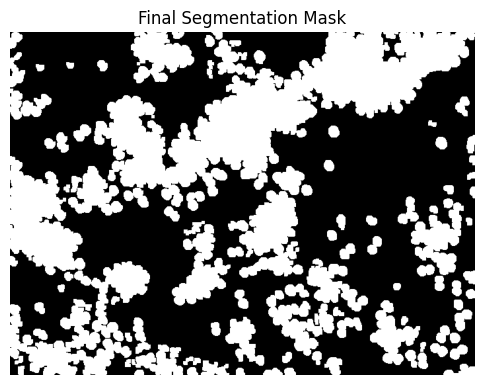

In [216]:
# create blank mask to visualize segmentation
seg_mask = np.zeros_like(cleaned)

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 1:
        cv2.drawContours(seg_mask, [cnt], -1, 255, -1)  # filled region

plt.figure(figsize=(6,6))
plt.imshow(seg_mask, cmap='gray')
plt.title("Final Segmentation Mask")
plt.axis('off')
plt.show()


Segmentation Performance Metrics:
Accuracy   : 87.72%
Precision  : 76.45%
Recall     : 92.22%
F1-score   : 83.60%
IoU (Jaccard): 71.82%
Dice Coefficient: 83.60%


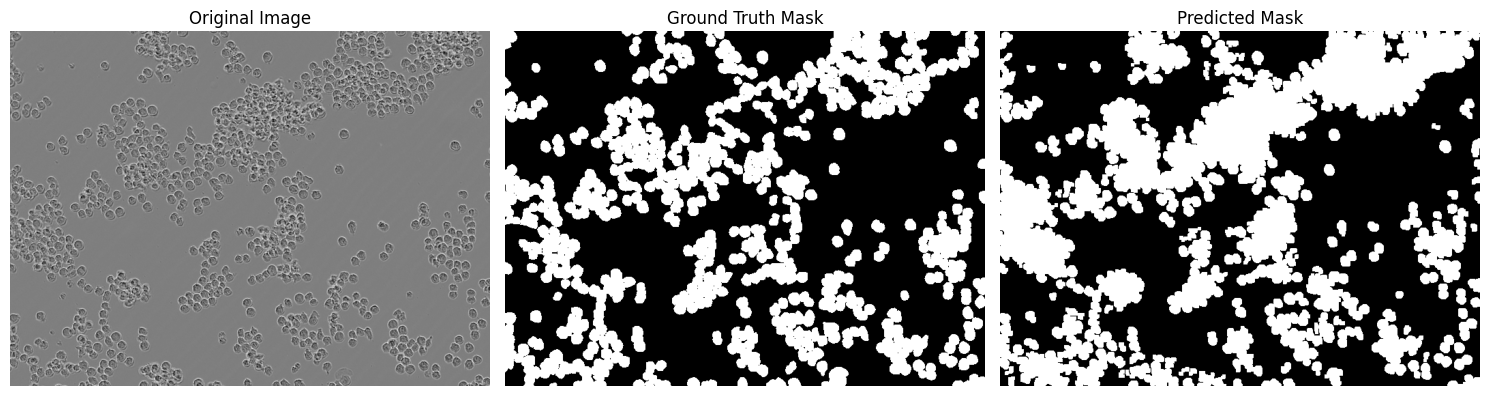

In [219]:
# Accuracy


import cv2
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Paths to your images ---
ground_truth_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/annotations/LIVECell/BV2_images/BV2_Phase_B4_1_02d00h00m_1.tif"
# predicted_path = "/path/to/predicted_mask.tif"

# --- Read images as grayscale ---
gt = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
#pred = cv2.imread(predicted_path, cv2.IMREAD_GRAYSCALE)
pred = seg_mask

# --- Resize predicted if needed ---
if gt.shape != pred.shape:
    pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))

# --- Binarize both images (0 and 1) ---
_, gt_bin = cv2.threshold(gt, 127, 1, cv2.THRESH_BINARY)
_, pred_bin = cv2.threshold(pred, 127, 1, cv2.THRESH_BINARY)

# --- Flatten for metric calculation ---
gt_flat = gt_bin.flatten()
pred_flat = pred_bin.flatten()

# --- Confusion Matrix ---
tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat).ravel()

# --- Metrics ---
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-8)
recall = tp / (tp + fn + 1e-8)
f1_score = 2 * precision * recall / (precision + recall + 1e-8)
iou = tp / (tp + fp + fn + 1e-8)
dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)

print("Segmentation Performance Metrics:")
print(f"Accuracy   : {accuracy * 100:.2f}%")
print(f"Precision  : {precision * 100:.2f}%")
print(f"Recall     : {recall * 100:.2f}%")
print(f"F1-score   : {f1_score * 100:.2f}%")
print(f"IoU (Jaccard): {iou * 100:.2f}%")
print(f"Dice Coefficient: {dice * 100:.2f}%")


img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15, 5))

# Original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted Result
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# --- Display ---
plt.tight_layout()
plt.show()


### Using Histogram Equalization for Metrics

While not directly for adaptive thresholding, histogram equalization can be useful for visualizing intensity distributions for metric analysis. For example:

1.  **Analyzing Intensity Distribution of Cells:** After segmentation, you could extract the pixel intensities within the segmented cell regions from the *original* or *enhanced* image and analyze their histogram. This could give you insights into the average brightness or intensity variation within cells, which might be a useful metric.
2.  **Evaluating Preprocessing Effectiveness:** You could compare the histograms of the original image, the Gaussian blurred image, and the histogram-equalized image to visually assess how each step affects the intensity distribution. This helps understand if your preprocessing is making the features you care about more distinct.

Here's an example of analyzing the histogram of pixel intensities within the segmented cell regions:

In [218]:
# # Assuming 'seg_mask' from your previous segmentation is available and represents the final cell mask (white pixels are cells)
# # seg_mask = np.zeros_like(img) # Remove this line as seg_mask is generated in a previous cell

# plt.hist(img.ravel(), bins=256, range=(0,255), color='gray')
# plt.title("Histogram of Original Image Pixel Intensities")
# plt.xlabel("Pixel Intensity")
# plt.ylabel("Frequency")
# plt.show()

# # Ensure seg_mask is binary (0 or 255)
# seg_mask_binary = (seg_mask > 0).astype(np.uint8) * 255

# # Extract pixel intensities from the original image where the mask is white (cells)
# cell_intensities = img[seg_mask_binary == 255]

# plt.figure(figsize=(6,4))
# plt.hist(cell_intensities.ravel(), bins=256, range=(0,255), color='#7074FB')
# plt.title("Histogram of Pixel Intensities within Cells")
# plt.xlabel("Pixel Intensity")
# plt.ylabel("Frequency")
# plt.show()

# # You could do the same for the CLAHE image:
# cell_intensities_clahe = clahe_img[seg_mask_binary == 255]
# plt.figure(figsize=(6,4))
# plt.hist(cell_intensities_clahe.ravel(), bins=256, range=(0,255), color='#FB20FB')
# plt.title("Histogram of Pixel Intensities within Cells (CLAHE Image)")
# plt.xlabel("Pixel Intensity")
# plt.ylabel("Frequency")
# plt.show()